In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import os
import math
from scipy import signal
import random
import keras
from keras import layers
import tensorflow as tf
import random

In [25]:
from numpy.polynomial.polynomial import Polynomial

def detrend_polynomial(data, degree = 2):
    x = np.arange(len(data))
    poly = Polynomial.fit(x, data, degree)
    trend = poly(x)
    return data - trend


In [26]:
beforeFiles = []
afterFiles = []
path = '/Users/henrywang/Documents/PPGCaffeineDetection/GlucoseReadings'
for dir in os.listdir(path):
    dir_path = os.path.join(path, dir)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            if os.path.isfile(file_path):
                if file == "AfterEating.txt":
                    afterFiles.append(file_path)
                if file == "BeforeEating.txt":
                    beforeFiles.append(file_path)


print(len(beforeFiles))
print(len(afterFiles))

                

17
17


In [27]:
def min_max_scaling(data):
    data = np.array(data)
    min_val = np.min(data)
    max_val = np.max(data)
    
    # Apply min-max scaling to [-1, 1]
    scaled_data = 2 * (data - min_val) / (max_val - min_val) - 1
    
    return scaled_data


In [28]:
#Function to have each sample on the start
from scipy.signal import find_peaks
def standardize_start(wave):
  troughsX, y = find_peaks(-wave, height = 200, distance = 60)
  previous = -1000
  start = []
  
  for i in troughsX:
    if i > previous + 1000:
      start.append(i)
      previous = i
  return start


In [29]:
time, y1, y2 = np.loadtxt("/Users/henrywang/Documents/PPGCaffeineDetection/GlucoseReadings/2024-09-07/AfterEating.txt", delimiter = ",", unpack=True)
fpass = 0.5
order = 2  # Filter order
y1 = -y1[20:]
y2 = -y2[20:]

sos = signal.butter(order, fpass, fs=100, btype='low', output='sos')

yFiltered1 = signal.sosfiltfilt(sos, y1)
yFiltered2 = signal.sosfiltfilt(sos, y2)
print(len(standardize_start(yFiltered1)))


12


In [30]:
beforeY1 = []
beforeY2 = []
# fpass = [0.5, 4]  # Passband frequency range
order = 2
for file in beforeFiles:
  time, y1, y2 = np.loadtxt(file, delimiter = ",", unpack=True)
  fpass = 0.5  # Passband frequency range
  order = 2  # Filter order
  y1 = -y1[20:]
  y2 = -y2[20:]

  sos = signal.butter(order, 5, fs=100, btype='lowpass', output='sos')

  yFiltered1 = signal.sosfiltfilt(sos, y1)
  yFiltered2 = signal.sosfiltfilt(sos, y2)

  starts = standardize_start(yFiltered1)

  for i in starts:
    if (i < len(yFiltered1) - 1100):
      beforeY1.append(min_max_scaling(detrend_polynomial(yFiltered1[i: i + 1000])))
      beforeY2.append(min_max_scaling(detrend_polynomial(yFiltered2[i: i + 1000])))

print(len(beforeY1))
print(len(beforeY2))

290
290


In [31]:
afterY1 = []
afterY2 = []
# fpass = [0.5, 4]  # Passband frequency range
order = 3
for file in afterFiles:
  time, y1, y2 = np.loadtxt(file, delimiter = ",", unpack=True)
  fpass = [0.7, 4]  # Passband frequency range
  order = 2  # Filter order
  y1 = -y1[20:]
  y2 = -y2[20:]

  sos = signal.butter(order, 5, fs=100, btype='lowpass', output='sos')

  yFiltered1 = signal.sosfiltfilt(sos, y1)
  yFiltered2 = signal.sosfiltfilt(sos, y2)

  starts = standardize_start(yFiltered1)

  for i in starts:
    if (i < len(yFiltered1) - 1100):
      afterY1.append(min_max_scaling(detrend_polynomial(yFiltered1[i: i + 1000])))
      afterY2.append(min_max_scaling(detrend_polynomial(yFiltered2[i: i + 1000])))

print(len(afterY1))
print(len(afterY2))

289
289


In [ ]:
# def add_noise():
  

In [32]:
zippedRandom = list(zip(afterY1 + beforeY1, afterY2 + beforeY2, [1] * len(afterY1) + [0] * len(afterY2)))

random.shuffle(zippedRandom)

shuffledY1, shuffledY2, label = zip(*zippedRandom)
trainX1 = []
trainX2 = []
testX1 = []
testX2 = []

trainY = []
testY = []

for i in range(0, len(shuffledY1)):
  if i < len(shuffledY1) * 0.8:
    trainX1.append(shuffledY1[i])
    trainX2.append(shuffledY2[i])
    trainY.append(label[i])
  else:
    testX1.append(shuffledY1[i])
    testX2.append(shuffledY2[i])
    testY.append(label[i])

print(len(trainX1))
print(len(testX1))

trainX1 = np.asarray(trainX1)
trainX2 =  np.asarray(trainX2)
testX1 =  np.asarray(testX1)
testX2 =  np.asarray(testX2)

trainY =  np.asarray(trainY)
testY =  np.asarray(testY)



463
115


In [33]:
import time
from IPython.display import clear_output

for i in range(10):
  plt.plot(trainX1[i])
  plt.show()
  time.sleep(1)
  clear_output()

Creating the model

In [44]:
from keras.regularizers import l2
fingerSequentialInput = keras.Input(shape = (1000))
toeSequentialInput = keras.Input(shape = (1000))


# finger2d500_1  = layers.Reshape((500, 1))(fingerSequentialInput)
# toe2d500_1  = layers.Reshape((500, 1))(toeSequentialInput)

fingerReshape2 = layers.Dense(128)(fingerSequentialInput)
toeReshape2 = layers.Dense(128)(toeSequentialInput)


pastFingerInput = fingerReshape2

pastToeInput =  toeReshape2

fingerCNN = layers.Dense(128)(fingerSequentialInput)
toeCNN = layers.Dense(128)(toeSequentialInput)
# for i in range(3):
#   fingerBatchNorm1 = layers.BatchNormalization()(fingerCNN)
#   toeBatchNorm1 = layers.BatchNormalization()(toeCNN)

#   fingerActivation1 = layers.Activation('relu')(fingerBatchNorm1)
#   toeActivation1 = layers.Activation('relu')(toeBatchNorm1)

#   fingerCNN2 = layers.Dense(128, activation = 'relu')(fingerActivation1)
#   toeCNN2 = layers.Dense(128, activation = 'relu')(toeActivation1)

#   fingerAdd = layers.add([fingerCNN2, pastFingerInput])
#   toeAdd = layers.add([toeCNN2, pastToeInput])

#   fingerCNN = layers.Dense(128, activation = "relu")(fingerAdd)
#   toeCNN = layers.Dense(128, activation = "relu")(toeAdd)

#   pastFingerInput = fingerAdd

#   pastToeInput =  toeAdd  

fingerCNN2 = layers.Dense(64)(fingerCNN)
toeCNN2 = layers.Dense(64)(toeCNN)


finger2d  = layers.Reshape((64, 1))(fingerCNN2)
toe2d  = layers.Reshape((64, 1))(toeCNN2)

fingerLSTM = layers.Bidirectional(layers.LSTM(32))(finger2d)
toeLSTM = layers.Bidirectional(layers.LSTM(32))(toe2d)


fingerCNN = layers.Dense(32, activation = "relu")(fingerLSTM)

toeCNN = layers.Dense(32, activation = "relu")(toeLSTM)


mergedLayer = layers.Concatenate()([fingerCNN2, toeCNN2])


finalOutput3 = layers.Dense(16, activation = "relu")(mergedLayer)

finalOutput2 = layers.Dense(8, activation = "relu")(finalOutput3)
finalOutput = layers.Dense(1, activation = "sigmoid")(finalOutput2)

mergeEpoch = 150
mergedModel = keras.Sequential()
mergedModel.reset_states()
mergedModel = keras.models.Model(inputs = [fingerSequentialInput, toeSequentialInput], outputs = finalOutput)
mergedModel.summary()

adamMergeOptimizer = keras.optimizers.legacy.Adam(learning_rate = 0.0001)
# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
mergedModel.compile(optimizer = adamMergeOptimizer, loss = "binary_crossentropy", metrics = ['accuracy'])

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 1000)]               0         []                            
                                                                                                  
 dense_128 (Dense)           (None, 128)                  128128    ['input_13[0][0]']            
                                                                                                  
 dense_129 (Dense)           (None, 128)                  128128    ['input_14[0][0]']            
                                                                                           

In [45]:
mergedModel = keras.Sequential()
mergedModel.reset_states()
mergedModel = keras.models.Model(inputs = [fingerSequentialInput, toeSequentialInput], outputs = finalOutput)

adamMergeOptimizer = keras.optimizers.legacy.Adam(learning_rate = 0.00001, amsgrad=True)
# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
mergedModel.compile(optimizer = adamMergeOptimizer, loss = "binary_crossentropy", metrics = ['accuracy'])

In [46]:
mergeEpoch = 500
mergeHistory = mergedModel.fit(x = [trainX1, trainX2], y = trainY, validation_data=([testX1, testX2], testY), batch_size=32, epochs = mergeEpoch)


Epoch 1/500
15/15 [==============================] - 2s 66ms/step - loss: 0.8333 - accuracy: 0.5356 - val_loss: 0.7966 - val_accuracy: 0.4957
Epoch 2/500
15/15 [==============================] - 0s 15ms/step - loss: 0.8092 - accuracy: 0.5313 - val_loss: 0.7906 - val_accuracy: 0.5217
Epoch 3/500
15/15 [==============================] - 0s 14ms/step - loss: 0.7923 - accuracy: 0.5378 - val_loss: 0.7916 - val_accuracy: 0.4696
Epoch 4/500
15/15 [==============================] - 0s 14ms/step - loss: 0.7806 - accuracy: 0.5486 - val_loss: 0.7947 - val_accuracy: 0.4783
Epoch 5/500
15/15 [==============================] - 0s 14ms/step - loss: 0.7742 - accuracy: 0.5400 - val_loss: 0.8003 - val_accuracy: 0.4870
Epoch 6/500
15/15 [==============================] - 0s 14ms/step - loss: 0.7717 - accuracy: 0.5551 - val_loss: 0.8049 - val_accuracy: 0.4870
Epoch 7/500
15/15 [==============================] - 0s 14ms/step - loss: 0.7687 - accuracy: 0.5486 - val_loss: 0.8071 - val_accuracy: 0.4870
Epoch 

In [ ]:
predictions = list(mergedModel.predict(x = [trainX1, trainX2]))
count = 0
zero = 0
for i in range(len(predictions)):
  count += 1
  
  if (predictions[i][0]) < 0.5:
    zero += 1
print(zero)
print(count)

19/19 [==============================] - 0s 4ms/step
582
582


(array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([8.86248245e-07, 2.78721927e-06, 4.68819053e-06, 6.58916133e-06,
        8.49013213e-06, 1.03911034e-05, 1.22920746e-05, 1.41930459e-05,
        1.60940162e-05, 1.79949875e-05, 1.98959588e-05]),
 <a list of 582 BarContainer objects>)

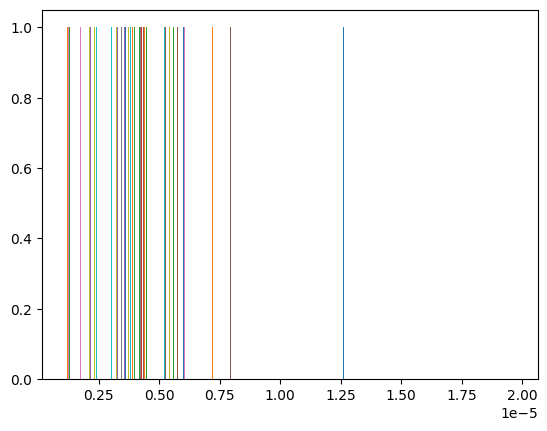

In [ ]:
plt.hist(predictions)